# PERCEPTRON introductory examples 


This code illustrates the behaviour of the perceptron using as many inputs as coordinates in 
an input sample (row), on a binary classification problem. The output decision function is the 
Heaviside step function. 

## 1. Description of the  toy data set
The data set below consists in a set of 10 samples in $\mathbb{R}^2$, containing 2 classes, as shown on the graph


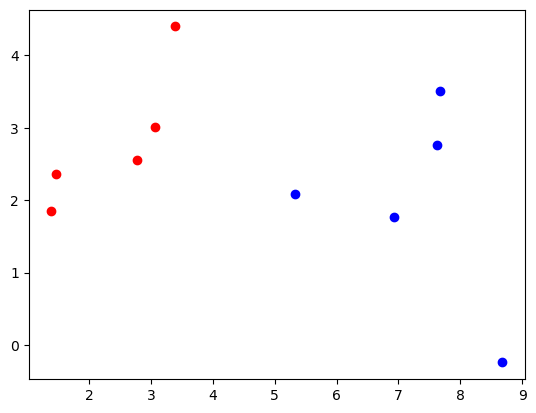

In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

dataset = [[2.7810836,2.550537003,0],
    [1.465489372,2.362125076,0],
    [3.396561688,4.400293529,0],
    [1.38807019,1.850220317,0],
    [3.06407232,3.005305973,0],
    [7.627531214,2.759262235,1],
    [5.332441248,2.088626775,1],
    [6.922596716,1.77106367,1],
    [8.675418651,-0.242068655,1],
    [7.673756466,3.508563011,1]]

data=np.asarray(dataset)
#print(data.shape)

dataP=data[data[:,2]==1,0:2]
dataN=data[data[:,2]==0,0:2]
plt.plot(dataP[:,0],dataP[:,1],'ob');
plt.plot(dataN[:,0],dataN[:,1],'or');


## 2. Define a single neuron, with a threshold  step activation function 

**" Predict"** function defined below,  computes 
$$ {\rm activation} = \sum_{k=0}^{{\rm dim}(X)} w[k].X[k] $$
where  $w[0]={\rm bias}$, and $w[k]$, $k=1,\ldots{\rm dim}(X)$ are the neuron inputs.  
The classification rule is defined at the output of the threshold function as 
$$ \hat{y} = \left\{ \begin{array}{ll} +1  \mbox{ if activation } \geq 0 \\
-1 \mbox{ if activation } < 0 \end{array} \right. $$

In [2]:
# Make a prediction with weights
def predict(sample, weights):
    activation = weights[0]
    for i in range(len(sample)):
        activation += weights[i + 1] * sample[i]
    #print(activation)
    prediction = 1.0 if activation >= 0.0 else 0.0
    return prediction,activation

### Questions 
- Show that the predict function defines an separation hyperplan in $\mathbb{R}^{{\rm dim}(X)}$
- Express the equation of the separation line as a function of the $\{w[k]\}$ in the case dim$(X)$=2
- Show in that latter case that setting $w[2]$=0 amounts to define a threshold on the first coordinate
- Propose a set of values for $\{w[0],w[1],w[2]\}$ which defines a good classifier for the data above. 

## 3. Apply 'Predict' to the data samples and vizualize the decision boundaries

In [3]:
w=np.zeros(3); 
w[0]=-4.5
w[1]=1
w[2]=0

weights = w

for row in dataset:
    sample=row[:-1]
    prediction,activation = predict(sample, weights)
    print("Expected=%d, Predicted=%d, activation=%.3f" % (row[-1], prediction, activation))

Expected=0, Predicted=0, activation=-1.719
Expected=0, Predicted=0, activation=-3.035
Expected=0, Predicted=0, activation=-1.103
Expected=0, Predicted=0, activation=-3.112
Expected=0, Predicted=0, activation=-1.436
Expected=1, Predicted=1, activation=3.128
Expected=1, Predicted=1, activation=0.832
Expected=1, Predicted=1, activation=2.423
Expected=1, Predicted=1, activation=4.175
Expected=1, Predicted=1, activation=3.174


#### Visualize the result for this classifier

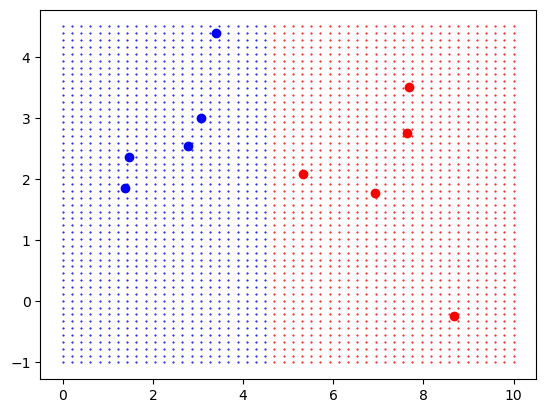

In [4]:
x=np.linspace(0,10,50)
y=np.linspace(-1,4.5,50)
X,Y= np.meshgrid(x,y)
XY = np.vstack([X.flatten(), Y.flatten()]).T
Z=[]

for sample in XY:
    z,a=predict(sample,weights)
    Z.append(z)
    
Z=np.asarray(Z)

plt.plot(dataP[:,0],dataP[:,1],'or')
plt.plot(dataN[:,0],dataN[:,1],'ob')
plt.scatter(XY[Z==0,0],XY[Z==0,1],s=1,c='b',marker='.')
plt.scatter(XY[Z==1,0],XY[Z==1,1],s=1,c='r',marker='.')
plt.show()

### Question :
* What is the equation of the boundary? 
* What is the value of the bias? 
* Is this solution unique? 

## 4. Learning weights : the perceptron as an approximate  SGD (Stochastic Gradient Descent)

We examine each of the training cases one at a time. For each input $X(i)$, we compute the prediction $y(i)$ and see if it matches the target $t(i)$. If the prediction is correct, we do nothing. If it is wrong, we adjust the weights in a direction that makes it more correct.
Let $z(i)=W^TX(i)$. The perceptron uses the strict criterion $z(i)t(i)>0$ (excludes the case where there may be a observation on the boundary). How is $W$ adjusted?
If the training case $X(i)$ is positive and we classify it as negative, we would like to increase $z(i)$ s.t. $W'^TX(i) > W^TX(i)=z(i)$ where $W′$ and $W$ are the new and old weight vectors, respectively. The
perceptron algorithm achieves this using the update $W'=W+\eta X(i)$. Actually, $W'^TX(i)=W^TX(i)+\eta||X(i||^2$. The converse reasoning holds for negative examples that are mistakenly classified as positive. 

##### Intrepretation as approximate SGD
Reformulate now the  problem as a regression one, i.e. finding $W$ s.t. $W^TX = y$, $y\in \{-1, +1\}$, using a quadratic loss (L) function. The gradient of the loss is $\sum_i -2X(i)(y(i)-W^TX(i))=\sum_i\nabla L(X(i))$. In a stochastic gradient framework, the Loss estimation and the udpate stage are evaluated for each single observation, and performed over many epochs. The update thus reads $W'=W+\alpha\nabla L(X(i))$.

For the perceptron algorithm, one approximates $L(X(i))\approx 0$ if the estimated label is correct and $L(X(i))\approx -4X(i)$ otherwise (note that $(y(i)-t(i)) \in \{+2,-2\}$). Thus leads to the perceptron function 'train_weights' below. 

In [5]:
# Estimate Perceptron weights
def train_weights(train, l_rate, n_epoch):
    weights = [0.0 for i in range(len(train[0]))]  # init weights are set to 0. 
    for epoch in range(n_epoch): # here, the number of epochs is set a priori. 
        sum_error = 0.0
        for row in train:  # .... for each observation,
            sample=row[:-1]
            prediction,activation = predict(sample, weights)
            error = row[-1] - prediction  # row[-1] refers to the last element in row (here, it is the label)
            sum_error += error**2
            weights[0] = weights[0] + l_rate * error  # l_rate = learing rate. 
            for i in range(len(sample)):   
                weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
        print('>epoch=%d, lrate=%.3f, error=%.3f' % (epoch, l_rate, sum_error))
    return weights

l_rate = 1
n_epoch =4
weights = train_weights(dataset, l_rate, n_epoch)
print(weights)


>epoch=0, lrate=1.000, error=2.000
>epoch=1, lrate=1.000, error=1.000
>epoch=2, lrate=1.000, error=0.000
>epoch=3, lrate=1.000, error=0.000
[-1.0, 2.0653640140000005, -2.341811771]


### Question
- How many operation (take only multiplicaiton into acocunt) are necessary to complete an epoch in the function train_weights defined above? 

### 5. Apply the weights estimated by approx SGD above and visualize classication results

This section proposes 3 methods to visualize the classification results :

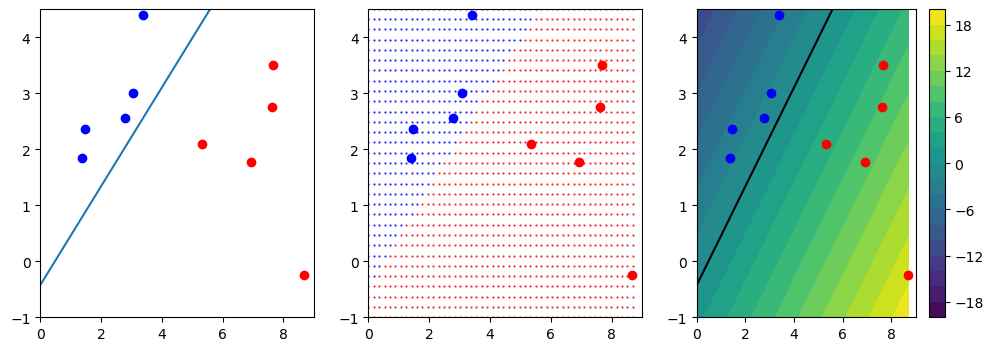

In [6]:
# prediction of labels using new weights
for row in dataset:
    sample=row[:-1]
    prediction,activation = predict(sample, weights)
    
# Visualization

plt.figure(figsize=[12,4])

# plot the separating hyperplane equation
plt.subplot(131)   
x=np.linspace(0,8.7,50)
yf = -weights[0]*np.ones_like(x)
yf += -weights[1]*x
yf /= weights[2] 

plt.plot(dataP[:,0],dataP[:,1],'or')
plt.plot(dataN[:,0],dataN[:,1],'ob')    
plt.axis([0, 9, -1, 4.5])
plt.plot(x,yf);

# test the sampled observation plane and plot the decision region 
plt.subplot(132) 
y=np.linspace(-1,8,50)
X,Y= np.meshgrid(x,y)
XY = np.vstack([X.flatten(), Y.flatten()]).T
Z=[]
A=[]
for sample in XY:
    z,a=predict(sample,weights)
    Z.append(z) , A.append(a)  # A contains the activation value
    
Z=np.asarray(Z)
A=np.asarray(A)

plt.plot(dataP[:,0],dataP[:,1],'or')
plt.plot(dataN[:,0],dataN[:,1],'ob')
plt.scatter(XY[Z==0,0],XY[Z==0,1],s=1,c='b',marker='.')
plt.scatter(XY[Z==1,0],XY[Z==1,1],s=1,c='r',marker='.')
plt.axis([0, 9, -1, 4.5])
xmin, xmax, ymin, ymax = plt.axis()
#plt.show()

# plot the values of the activation values obtained by sampling the observation plane
plt.subplot(133) 
A=np.reshape(A,[x.size,y.size])
plt.contourf(X,Y,A, levels=20)
plt.plot(dataP[:,0],dataP[:,1],'or')
plt.plot(dataN[:,0],dataN[:,1],'ob')
plt.plot(x,yf,'k');
plt.axis([xmin, xmax, ymin, ymax])
plt.colorbar()

### Question 
- Which of the three representations above is the more informative? 

### 6. Using Scikit-learn perceptron function
https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptronlen(dataset)

Estimates weights =[-1.          2.06536401 -2.34181177]


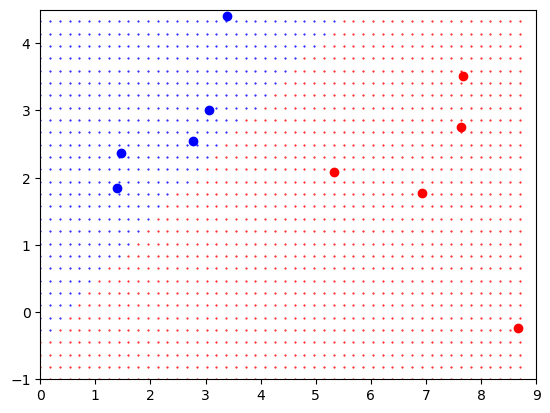

In [10]:
from sklearn.linear_model import Perceptron

X=[] 
y=[]
for i in range(len(dataset)):
    X.append(dataset[i][:-1])
    y.append(dataset[i][-1])


clf = Perceptron(eta0=1,fit_intercept=True, max_iter=1000, n_iter_no_change=5, \
                 random_state=0, shuffle=False, tol=0.001, \
                 validation_fraction=0.1)
clf.fit(X,y)
w=np.zeros(3)
w[0]=clf.intercept_
w[1:3]=clf.coef_
print("Estimates weights ={}".format(w))

# Visu of decision regions
x=np.linspace(0,8.7,50)
y=np.linspace(-1,8,50)
X,Y= np.meshgrid(x,y)
XY = np.vstack([X.flatten(), Y.flatten()]).T

Z=clf.predict(XY)

plt.plot(dataP[:,0],dataP[:,1],'or')
plt.plot(dataN[:,0],dataN[:,1],'ob')
plt.scatter(XY[Z==0,0],XY[Z==0,1],s=1,c='b',marker='.')
plt.scatter(XY[Z==1,0],XY[Z==1,1],s=1,c='r',marker='.')
plt.axis([0, 9, -1, 4.5]);
#xmin, xmax, ymin, ymax = plt.axis()

### Question
- Using the sklearn reference documentation, identify the role of the parameters "Shuffle" and "Validation_fraction". Set "Shuffle" to False then True and comment your results. 
- Discuss the interest of introducing such parameters
- What was the value of parameter "eta0" in our "train_weights" code? 
- Change eta_0 from value 1 to value .1. Explain your findings.  

## 7. Problem : 

A two class problem is considered, for concentric anulus classes. 
The data are synthetized then represented below :

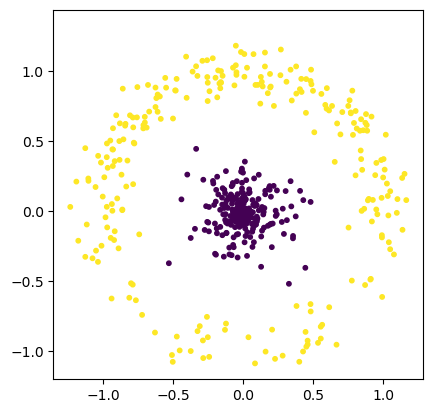

In [8]:
import numpy as np

std=.1
N=250

M1=(np.random.randn(N)*std+1)
P1=(np.random.rand(N)*3*np.pi)
y1=np.ones(len(M1))
M2=(np.random.randn(N)*std*2)
P2=(np.random.rand(N)*2*np.pi)
y2=np.ones(len(M1))*-1
M=np.concatenate((M1,M2))
P=np.concatenate((P1,P2))

X=np.column_stack((M,P))
label=np.concatenate((y1,y2))

data=np.multiply(M,np.exp(1j*P))
plt.scatter(data.real,data.imag,c=label,s=10)
plt.axis('square');
#plt.plot(M,'or')
#plt.plot(P,'ob')


### Question 
- Do you think that a perceptron (also called single layer perceptron) is a performant classifier for this problem?

Learning the perceptron from the learning set (X,y) and visulizing the decision region is performed below:

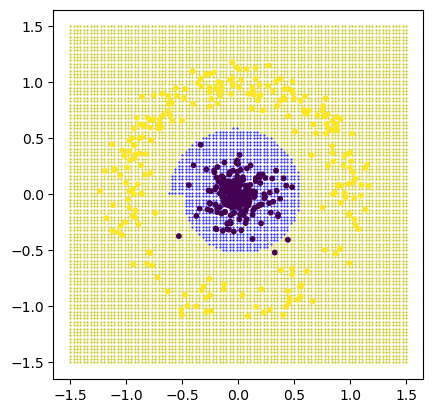

In [9]:

clf = Perceptron(eta0=.1,fit_intercept=True, max_iter=10000, n_iter_no_change=5, \
                 random_state=0, shuffle=True, tol=0.001, \
                 validation_fraction=0.1,warm_start=True)
clf.fit(X,label)

# Visu of decision regions
x=np.linspace(-1.5,1.5,100)
y=np.linspace(-1.5,1.5,100)
xx,yy= np.meshgrid(x,y)
XY = np.vstack([xx.flatten(), yy.flatten()]).T

XVisu = np.zeros((len(XY),2))
for i in range(len(XVisu)):
    XVisu[i][0]=np.sqrt(np.sum(XY[i]**2))
    XVisu[i][1]=np.angle(XY[i][0]+1j*XY[i][1])
    
Z=clf.predict(XVisu)   
plt.scatter(XY[Z==-1,0],XY[Z==-1,1],s=1,c='b',marker='.')
plt.scatter(XY[Z==1,0],XY[Z==1,1],s=1,c='y',marker='.')
plt.scatter(data.real,data.imag,c=label,s=10)
plt.axis('square');

### Question 
- Run the code above a few times : descibe the shape of the decision regions that you obtain
- Is it in contradiction with the property of (single layer) perceptron stating that their are linear separators?
- What do you conclude about the choice of the representation space of the analyzed data?